# Ciencia de Datos I<a class="tocSkip">
## Electiva Procesamiento de Señales I <a class="tocSkip">
### Ingenieria Electrónica <a class="tocSkip">
### Universidad Popular del Cesar <a class="tocSkip">
### Prof.: Jose Ramón Iglesias Gamarra - [https://github.com/joseramoniglesias/](https://github.com/joseramoniglesias/) <a class="tocSkip">
  **joseiglesias@unicesar.edu.co**

# 0. Setup

## Libraries

In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from   skimage.measure   import label
from   sklearn.metrics   import confusion_matrix, accuracy_score
import skimage
import cv2
from   scipy.ndimage import binary_fill_holes
from   skimage.segmentation import find_boundaries
from matplotlib.patches import Ellipse

# Funciones Básicas

In [23]:
def basicgeo(R,names=False):
    # center of mass
    ij = np.argwhere(R)
    ii = ij[:,0]
    jj = ij[:,1]
    i_m = np.mean(ii)
    j_m = np.mean(jj)

    # height
    h = np.max(ii)-np.min(ii)+1

    # width
    w = np.max(jj)-np.min(jj)+1

    # area
    area = np.sum(R)

    # perimeter
    # https://scikit-image.org/docs/stable/api/skimage.segmentation.html#skimage.segmentation.find_boundaries
    B = skimage.segmentation.find_boundaries(R,mode='inner')
    perimeter = np.sum(B)


    # regionprops
    # https://scikit-image.org/docs/stable/api/skimage.measure.html#regionprops
    props        = skimage.measure.regionprops(R)[0]

    #perimeter    = props.perimeter
    roundness    = 4*area*np.pi/perimeter/perimeter
    solidity     = props.solidity
    euler_number = props.euler_number
    eq_diameter  = props.equivalent_diameter_area
    axis_major   = props.axis_major_length
    axis_minor   = props.axis_minor_length
    orientation  = props.orientation
    extent       = props.extent
    eccentricity = props.eccentricity
    area_convex  = props.area_convex

    # roundness
    #roundness    = 4*area*np.pi/perimeter/perimeter

    X = [i_m,j_m,h,w,area,perimeter,roundness,
         euler_number,eq_diameter,axis_major,axis_minor,
         orientation,solidity,extent,
         eccentricity,area_convex]
    if names:
        Xn = ['i_m','j_m','height','width','area','perimeter','roundness',
              'euler_number','equivalent_diameter','major_axis','minor_axis',
              'orientation','solidity','extent',
              'eccentricity','convex_area_convex']
        return X,Xn
    else:
        return X

def fitellipse(R,names=False):
    E        = find_boundaries(R, mode='outer').astype(np.uint8)
    # E        = bwperim(R)
    data     = np.argwhere(E==True)
    y        = data[:,0]
    x        = data[:,1]
    X       = fit_ellipse(x,y)
    if names:
        Xn = ['cx','cy','a','b','alpha','ecc','area']
        return X,Xn
    else:
        return X
    return features

def fit_ellipse(x,y):
    # Fitzgibbon, A.W., Pilu, M., and Fischer R.B., 
    # Direct least squares fitting of ellipses, 1996
    x        = x[:,None]
    y        = y[:,None]
    D        = np.hstack([x*x,x*y,y*y,x,y,np.ones(x.shape)])
    S        = np.dot(D.T,D)
    C        = np.zeros([6,6])
    C[0,2]   = C[2,0] = 2
    C[1,1]   = -1
    E,V      = np.linalg.eig(np.dot(np.linalg.inv(S),C))
    n        = np.argmax(E)
    s        = V[:,n]
    a        = s[0]
    b        = s[1]/2.
    c        = s[2]
    d        = s[3]/2.
    f        = s[4]/2.
    g        = s[5]
    dd       = b*b-a*c
    cx       = (c*d-b*f)/dd
    cy       = (a*f-b*d)/dd
    alpha    = 0.5*np.arctan(2*b/(a-c))*180/np.pi
    up       = 2*(a*f*f+c*d*d+g*b*b-2*b*d*f-a*c*g)
    down1    = (b*b-a*c)*( (c-a)*np.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
    down2    = (b*b-a*c)*( (a-c)*np.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
    a        = np.sqrt(abs(up/down1))
    b        = np.sqrt(abs(up/down2))
    area     = np.pi*a*b

    if b>a:
        ecc  = a/b
    else:
        ecc  = b/a

    features = [cx,cy,a,b,alpha,ecc,area]

    return features


def hugeo(R,names=False):
    # regionprops
    # https://scikit-image.org/docs/stable/api/skimage.measure.html#regionprops
    props = skimage.measure.regionprops(R)[0]

    X = props.moments_hu

    if names:
        Xn = ['Hu-moment-1','Hu-moment-2','Hu-moment-3','Hu-moment-4','Hu-moment-5','Hu-moment-6','Hu-moment-7']
        return X,Xn
    else:
        return X

def flusser(R,names=False):
    moments = cv2.moments(R, True)
    u00,u20, u11, u02, u30, u21, u12, u03 = moments['m00'], moments['mu20'], moments['mu11'], moments['mu02'], moments['mu30'], moments['mu21'], moments['mu12'], moments['mu03']
    I1 = (u20*u02-u11**2)/u00**4 ;
    I2 = (u30**2*u03**2-6*u30*u21*u12*u03+4*u30*u12**3+4*u21**3*u03-3*u21**2*u12**2)/u00**10;
    I3 = (u20*(u21*u03-u12**2)-u11*(u30*u03-u21*u12)+u02*(u30*u12-u21**2))/u00**7;
    I4 = (u20**3*u03**2-6*u20**2*u11*u12*u03-6*u20**2*u02*u21*u03+9*u20**2*u02*u12**2 + 12*u20*u11**2*u21*u03+6*u20*u11*u02*u30*u03-18*u20*u11*u02*u21*u12-8*u11**3*u30*u03- 6*u20*u02**2*u30*u12+9*u20*u02**2*u21+12*u11**2*u02*u30*u12-6*u11*u02**2*u30*u21+u02**3*u30**2)/u00**11;
    X = [I1,I2,I3,I4]
    if names:
        Xn = ['Flusser-1','Flusser-2','Flusser-3','Flusser-4']
        return X,Xn
    else:
        return X

    def gupta(R, names=False):
        B = skimage.segmentation.find_boundaries(R,mode='inner')
        i_perim, j_perim = np.where(B.astype(bool))
        im_perim = i_perim + j_perim * 1j
        ix = i_perim.mean()
        jx = j_perim.mean()
        centre = ix + jx * 1j
        z = np.abs(im_perim - centre)
        m1 = z.mean()

        mur1 = z - m1
        mur2 = mur1 * mur1
        mur3 = mur1 * mur2
        mur4 = mur2 * mur2

        mu2 = mur2.mean()
        mu3 = mur3.mean()
        mu4 = mur4.mean()

        F1 = (mu2 ** .5) / m1
        F2 = mu3 / (mu2 * (mu2 ** .5))
        F3 = mu4 / mu2 ** 2

        X = np.array([F1, F2, F3])

    if names:
        Xn = ['Gupta-1','Gupta-2','Gupta-3']
        return X,Xn
    else:
        return X

    def plot_ellipses_image(I,x,y=0):
        if y==0:
            x,y  = get_ellipse_path(x)
    fig=plt.figure()
    ax2=fig.add_subplot(111)
    implot = plt.imshow(I,cmap='gray')
    ax2.plot(x,y,'-',color='Red')
    plt.show()

    def get_ellipse_path(params):
        cx    = params[0]
    cy    = params[1]
    a     = params[2]
    b     = params[3]
    alpha = params[4]
    ell   = Ellipse((cx,cy),a*2.,b*2.,alpha)
    coord = ell.get_verts()
    xs    = coord[:,0]
    ys    = coord[:,1]
    return xs,ys

def imageload(prefix,num_class,digits_class,num_img,digits_img,sep='_',echo='off'):
    st   = prefix + num2fixstr(num_class,digits_class) + sep + num2fixstr(num_img,digits_img) + '.png'
    if echo == 'on':
        print('loading image '+st+'...')
    img    = plt.imread(st)
    return img

def plot_ellipses(ellipse_list):
    '''Plot a list of ellipses'''
    fig=plt.figure()
    ax2=fig.add_subplot(111)
    n = len(ellipse_list)
    for i in range(n):
        cii = ellipse_list[i]
        x=cii[:,0]
        y=cii[:,1]
        if i==0:
            ax2.plot(x,y,'.')
        else:
            ax2.plot(x,y,'-')
    plt.show()

def plot_ellipses_image(I,x,y=0):
    if y==0:
       x,y  = get_ellipse_path(x)
    fig=plt.figure()
    ax2=fig.add_subplot(111)
    implot = plt.imshow(I,cmap='gray')
    ax2.plot(x,y,'-',color='Red')
    plt.show()

def get_ellipse_path(params):
    cx    = params[0]
    cy    = params[1]
    a     = params[2]
    b     = params[3]
    alpha = params[4]
    ell   = Ellipse((cx,cy),a*2.,b*2.,alpha)
    coord = ell.get_verts()
    xs    = coord[:,0]
    ys    = coord[:,1]
    return xs,ys

def num2fixstr(x,d):
    st = '%0*d' % (d,x)
    return st

# Example 1: Basic geometric features

In this example, we show how to extract the basic geometric features of ten segmented blocks in the X-ray image N0001_0004b.png. The segmentation in this example is performed by thresholding the X-ray image and selecting those segmented objects that present a suitable size (area).

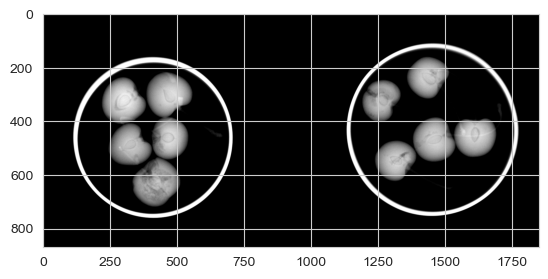

In [4]:
# Input Image
fig    = plt.figure()
ax     = fig.add_subplot(111)
img1   = plt.imread('N0001_0004b.png')
implot = plt.imshow(img1,cmap='gray')


In [5]:
# Input Image
img    = img1

# Segmentation
R      = img>0.27         # thresholding of light objects
L      = label(R)         # labeling of objects
n      = np.max(L)        # number of detected objects
T      = np.zeros((n,16)) # features of each object will stored in a row

# Analysis of each segmented object
t      = 0 # count of recognized fruits
for i in range(n):
    R = (L == i)*1                         # binary image of object i
    f = basicgeo(R)  # feature extraction for object i
    area = f[4]
    # recognition of fruits according to the size
    if area>14000 and area<21000:
        T[t,:] = f                         # storing the features of the fruit t
        t = t+1
        # labeling each recognized fruit in the plot
        ax.text(f[1]-20, f[0]+10, str(t), fontsize=12,color='Red')

# Display and save results
plt.show()
F = T[0:t,:]
print('Basic Geo-Features:')
print(F)
np.save('GeoFeatures.npy',F)               # save features

Basic Geo-Features:
[[ 2.37110881e+02  1.43387875e+03  1.48000000e+02  1.50000000e+02
   1.59180000e+04  4.19000000e+02  1.13938453e+00  1.00000000e+00
   1.42363714e+02  1.51618715e+02  1.35257149e+02 -6.73321530e-01
   9.80474284e-01  7.17027027e-01  4.51862841e-01  1.62350000e+04]
 [ 3.01101918e+02  4.66628467e+02  1.67000000e+02  1.64000000e+02
   1.93980000e+04  4.75000000e+02  1.08038762e+00 -1.00000000e+00
   1.57156930e+02  1.66073138e+02  1.51188773e+02 -9.95426947e-01
   9.74284279e-01  7.08266394e-01  4.13784992e-01  1.99100000e+04]
 [ 3.28325695e+02  2.97191754e+02  1.69000000e+02  1.58000000e+02
   1.91130000e+04  4.59000000e+02  1.14002232e+00  1.00000000e+00
   1.55998165e+02  1.65698708e+02  1.49042889e+02  2.88540434e-01
   9.72473797e-01  7.15789079e-01  4.36959264e-01  1.96540000e+04]
 [ 3.23035395e+02  1.26024958e+03  1.48000000e+02  1.37000000e+02
   1.43240000e+04  4.52000000e+02  8.81043409e-01  1.00000000e+00
   1.35047707e+02  1.56864124e+02  1.19141779e+02 -4.

# Example 2: Elliptical Features

In this example, we show how to extract elliptical features from the outline of a fruit. We tested this method on an X-ray of a cherry with an elliptical shape as shown in the result.

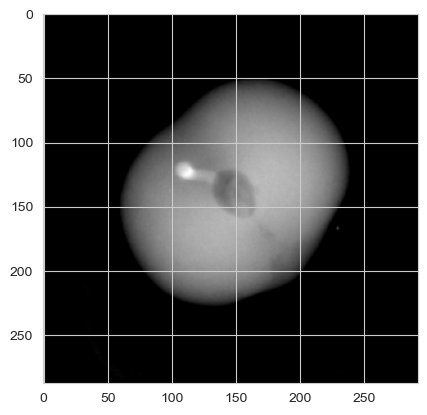

In [6]:
# Input Image
fig    = plt.figure()
ax     = fig.add_subplot(111)
img2   = plt.imread('N0006_0003b.png')
implot = plt.imshow(img2,cmap='gray')


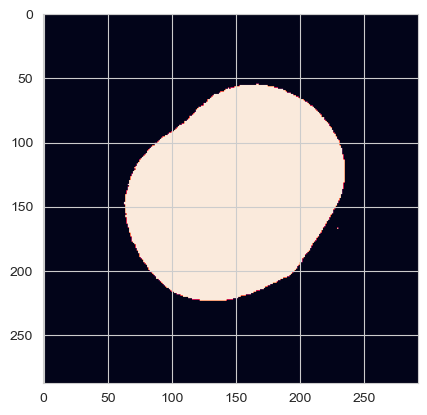

In [7]:
img    = img2   # input image with a fruit
R = img>0.2     # segmentation
plt.imshow(R)
plt.show()

Elliptical Features:
[149.37312970213804, 140.1603157123134, 92.58829192725108, 74.15304692794595, -42.92092966456701, 0.8008901059132816, 21569.245110708194]


C:\Users\joser\AppData\Local\Temp\ipykernel_6332\2049711012.py:226: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell   = Ellipse((cx,cy),a*2.,b*2.,alpha)


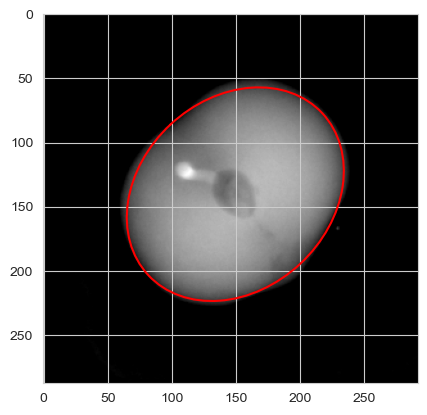

Note: The 7 values are: [Mass center: (io,jo) in pixels; Axis: (ae,be) in pixels; Orientation in grads; Eccentricity; Area in pixels]


In [20]:
fxell  = fitellipse(R)                           # extraction of elliptical features
print('Elliptical Features:')                    # show results
print(fxell)                                     # print elliptical features
plot_ellipses_image(img,fxell)                   # draw ellipse onto image
print('Note: The 7 values are: [Mass center: (io,jo) in pixels; Axis: (ae,be) in pixels; Orientation in grads; Eccentricity; Area in pixels]')

# Example 3: Invariant moments

In this example, we show how to measure invariant moments that can be used as shape features of objects of interest. We test this method with an X-ray containing 10 apples. We superimpose on this image 4 rectangles whose size is $a \times b$ pixels (where $b=3a$). The rectangles are located in the horizontal and vertical directions, as shown in the result. Thus, we can simulate an input X-ray image containing apples and rectangles. The idea is to separate them. We see that the first Hu-moment can be used to effectively discriminate apples from rectangles.

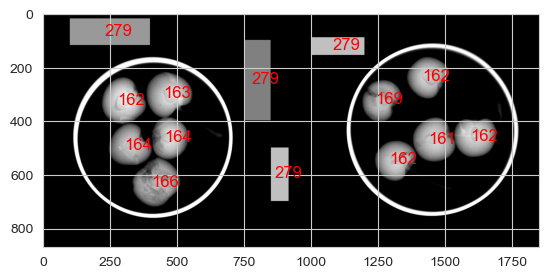

Hu Features:
[[ 2.79269844e-01  5.02170131e-02  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.78888128e-01  5.00078881e-02  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.79269844e-01  5.02170131e-02  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.62091387e-01  3.39641538e-04  1.01449954e-04  1.29613440e-06
  -1.32750022e-11 -2.03144012e-08  6.68412276e-12]
 [ 1.62511380e-01  2.31495542e-04  1.88649432e-04  1.69404653e-06
  -3.02449754e-11 -2.57072630e-08  1.54037077e-12]
 [ 1.62421665e-01  2.93861446e-04  1.29347691e-04  1.46554367e-06
  -1.63641293e-11 -1.07630449e-08  1.18053281e-11]
 [ 1.69301159e-01  2.06379006e-03  8.88690655e-05  2.20118391e-06
  -3.01864184e-11 -9.86463800e-08  6.04867570e-12]
 [ 1.63674728e-01  1.04829194e-03  7.22197545e-05  1.24391190e-06
  -1.02165115e-11 -3.43974286e-08  5.88439607e-12]
 [ 1.61481567e-01  2.46151206e-04  7.51875126e-05  

In [21]:
fig    = plt.figure()
ax     = fig.add_subplot(111)
img    = img1
img[100:399,750:849]  = 0.5
img[500:699,850:916]  = 0.75
img[20:119,100:399]   = 0.6
img[90:156,1000:1199] = 0.75
implot = plt.imshow(img,cmap='gray')
R      = img>0.27   # segmentation
L      = label(R)   # labeling
n      = np.max(L)  # number of segmented objects
t      = 0
T      = np.zeros((n,7))
for i in range(n):
    R = (L == i)*1                      # binary image of object i
    f = basicgeo(R)
    area = f[4]
    # recognition of fruits according to the size
    if area>10000 and area<31000:
        h  = hugeo(R)
        T[t,:] = h
        t      = t+1
        x      = round(1000*h[0])       # first hu moment
        ax.text(f[1]-20, f[0]+10, str(int(x)), fontsize=12,color='Red')
plt.show()
F = T[0:t,:]
print('Hu Features:')
print(F)
np.save('HuFeatures.npy',F)             # save features

Note: In this example, the features (basic geometric features for centroid and area, and Hu moments) are computed by  function `extract_features` of PyXvis  with parameters `['basicgeo','hugeo']` and `bw=R`, where `R` is the binary image from which the features are extracted. The output of this function is a vector `f` computed by concatenation of two vectors, one for the basic geometric features (of 18 elements) and one for the Hu moments (of 7 elements). Thus, the first Hu moment is stored in `f[18]`. The reader can test Flusser and Gupta moments using functions parameters `'flusser'` and `'gupta'` respectively in function `extract_features`.

# Example 4: Recognition of Arrows

In this example, three types of arrows are recognized as shown in the figure. The arrows are of different sizes and different orientations.

* Class 0: curved unidirectional arrow

* Class 1: bidirectional straight arrow

* Class 2: unidirectional straight arrow

The Hu moments are used for the solution since they are invariant to rotation and scale.

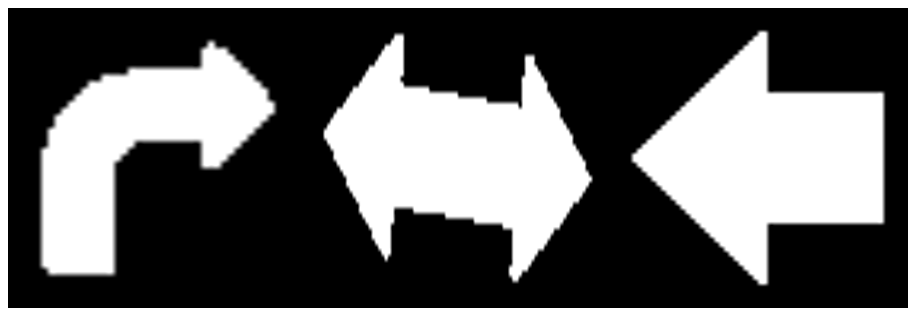

In [30]:
# Training subset: 3 classes and 12 images per class

# Usar arrows_training.zip que esta en el Github

In [31]:
# Testing subset: 3 classes and 10 images per clase

# Usar arrows_testing.zip que está en el Github

In [24]:
# TRAINING

K = 3  # number of classes
N = 12 # number of images per class

M  = 7    # Hu moments are 7
#M  = 4   # Flusser moments are 4
#M  = 3   # Gupta moments are 3


Xtrain = np.zeros((K*N,M))          # K x N samples and  M features
ytrain_gt = np.zeros((K*N,))        # ground truth

t = 0
for j in range(K):
  for i in range(N):

    img    = imageload('arrows_training/arrow',j+1,2,i+1,2)
    R      = (img>0.5)*1            # segmentation
    f = hugeo(R)      # feature extraction
    #f = flusser(R)   # feature extraction
    #f = gupta(R)     # feature extraction
    Xtrain[t,:] = f
    ytrain_gt[t] = j
    t = t+1


In [25]:
# TESTING

Nt = 10

Xtest = np.zeros((K*Nt,M))          # features
ytest_gt = np.zeros((K*Nt,))        # ground truth

t = 0
for j in range(K):
  for i in range(Nt):
    img    = imageload('arrows_testing/arrow',j+1,2,i+1,2)
    R      = (img>0.5)*1            # segmentation
    f = hugeo(R)   # feature extraction
    #f = flusser(R)   # feature extraction
    #f = gupta(R)   # feature extraction
    Xtest[t,:] = f
    ytest_gt[t] = j
    t = t+1


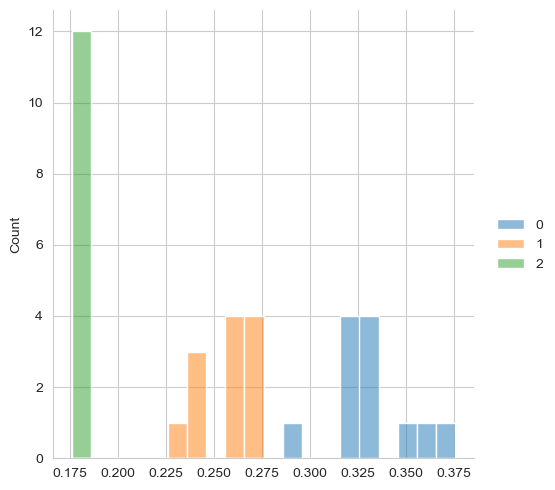

In [26]:
# Frequency distribution by class
# Hu moments are 7, and they have been stored as 7 columns in the matrix
# Xtrain, the first Hu moment is column zero:
mm = 0 # 0 is the first moment, 1 is the second one, etc.!
sns.displot([Xtrain[0:12,mm],Xtrain[12:24,mm],Xtrain[24:36,mm]],bins=20)


In [27]:
# Classification
# Clearly the classes are separated with two thresholds which in this case are chosen
# manually:

th1 = 0.20
th2 = 0.28

xtest  = Xtest[:,mm]
n = K*Nt
ytest  = np.zeros((n,))
for i in range(n):
  if xtest[i]<th1:
    ytest[i] = 2
  elif xtest[i]<th2:
    ytest[i] = 1


In [28]:
# Performance

C = confusion_matrix(ytest_gt, ytest)
print('Confusion Matrix:')
print(C)
print(' ')
Acc = accuracy_score(ytest_gt, ytest)
print('Accuracy:')
print(Acc)


Confusion Matrix:
[[10  0  0]
 [ 0 10  0]
 [ 0  0 10]]
 
Accuracy:
1.0


**Copyright**

The notebooks are provided as [Open Educational Resource](https://de.wikipedia.org/wiki/Open_Educational_Resources). Feel free to use the notebooks for your own educational purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT).